a)

Trend component g_t is a random walk with drift. This implies that the trend evolves over time through the accumulation of past values and stochastic innovations. The drift term "a" captures the average growth rate of output, while the shock e_t introduces fluctuations around this growth path. This process is non-stationary, meaning its statistical properties such as the mean and variance are not constant over time. Because the error terms accumulate, the variance of g_t increases all the time, reflecting that the long-term level of output is uncertain and can change. Over the long run, the trend can be persistent upward or downward movement depending on the direction and size of the shocks and the value of the drift. 


Cycle component c_t is a ARMA(2,1) model. Autoregressive terms B_1 and B_2 describe how past values of the cycle affect its current value, while the moving average term θ captures how past shocks influence the cycle. If the roots of the polynomial lie outside the unit circle, this process is stationary, meaning that the cycle has a constant mean, finite variance, and autocorrelations that decay over time. Therefore, the cyclical component reflects temporary deviations from the long-run trend that eventually goes away.



In the long run, the trend component dominates the behavior of output, as it evolves permanently due to its non-stationary nature. In contrast, the cycle fluctuates around zero and has no long-term impact on the level of output. This is important central banks who are concerned with the cyclical component (output gap) when designing policies. 

b)

formulas are in my notebook.

c)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
np.random.seed(2)

T = 300
a = 0.02
sigma_e2 = 0.5
sigma_u2 = 0.5
B1 = 0.8
B2 = 0.0
theta = 1.0

mu = np.array([a, 0, 0, 0])
F = np.array([
    [1,   0,   0,    0],
    [0,  B1,  B2, theta],
    [0,   1,   0,    0],
    [0,   0,   0,    0]
])
G = np.array([
    [1, 0],
    [0, 1],
    [0, 0],
    [0, 0]
])
H = np.array([1, 1, 0, 0])

beta = np.zeros((T, 4))
epsilons = np.random.normal(0, [np.sqrt(sigma_e2), np.sqrt(sigma_u2)], size=(T, 2))
y = np.zeros(T)

#initial beta
beta_0 = np.zeros(4)



In [3]:
for t in range(T):
    if t == 0:
        beta[t] = mu + F @ beta_0 + G @ epsilons[t]
    else:
        beta[t] = mu + F @ beta[t-1] + G @ epsilons[t]
    y[t] = H @ beta[t]

In [4]:
g = beta[:, 0]
c = beta[:, 1]

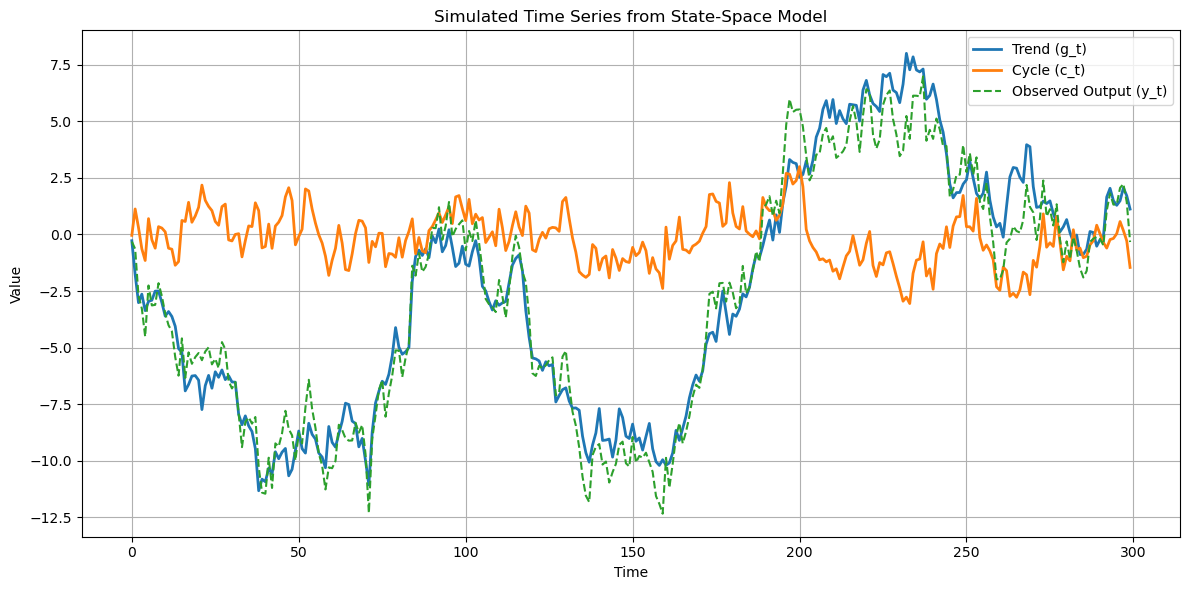

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(g, label='Trend (g_t)', linewidth=2)
plt.plot(c, label='Cycle (c_t)', linewidth=2)
plt.plot(y, label='Observed Output (y_t)', linestyle='--')
plt.title('Simulated Time Series from State-Space Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The simulated output series y_t ​ reflects both long-term growth driven by the trend g_t , and temporary business cycle fluctuations represented by the cycle c_t ​. The trend evolves as a persistent random walk with drift, while the cycle fluctuates around zero in a mean-reverting fashion, consistent with an ARMA(2,1) process.

d)

In [6]:
np.random.seed(2)
T = 300
a_true = 0.02
B1_true = 0.8
B2_true = 0.0
theta_true = 1.0
sigma_e2_true = 0.5
sigma_u2_true = 0.5

mu = np.array([a_true, 0, 0, 0])
F = np.array([
    [1, 0, 0, 0],
    [0, B1_true, B2_true, theta_true],
    [0, 1, 0, 0],
    [0, 0, 0, 0]
])
G = np.array([
    [1, 0],
    [0, 1],
    [0, 0],
    [0, 0]
])
H = np.array([1, 1, 0, 0])

epsilons = np.random.normal(0, [np.sqrt(sigma_e2_true), np.sqrt(sigma_u2_true)], size=(T, 2))
beta = np.zeros((T, 4))
y = np.zeros(T)

In [7]:
for t in range(T):
    if t == 0:
        beta[t] = mu + G @ epsilons[t]
    else:
        beta[t] = mu + F @ beta[t-1] + G @ epsilons[t]
    y[t] = H @ beta[t]

g_true = beta[:, 0]
c_true = beta[:, 1]

K-Filter

In [8]:
def kalman_filter_loglik(params, y):
    a, B1, B2, theta, log_sigma_e2, log_sigma_u2 = params
    sigma_e2 = np.exp(log_sigma_e2)
    sigma_u2 = np.exp(log_sigma_u2)

    mu = np.array([a, 0, 0, 0])
    F = np.array([
        [1, 0, 0, 0],
        [0, B1, B2, theta],
        [0, 1, 0, 0],
        [0, 0, 0, 0]
    ])
    G = np.array([
        [1, 0],
        [0, 1],
        [0, 0],
        [0, 0]
    ])
    Q = np.diag([sigma_e2, sigma_u2])
    H = np.array([1, 1, 0, 0])
    R = 0

    T = len(y)
    beta_hat = np.zeros((T, 4))
    P = np.eye(4) * 1000
    logL = 0

#same as in the book
    for t in range(T):
        if t == 0:
            beta_pred = mu # first prediction from drift
        else:
            beta_pred = mu + F @ beta_hat[t-1] # state prediction

        P = F @ P @ F.T + G @ Q @ G.T #covariance pred
        y_pred = H @ beta_pred
        eta = y[t] - y_pred
        S = H @ P @ H.T + R
        K = P @ H.T / S
        beta_hat[t] = beta_pred + (K * eta).flatten()
        P = P - np.outer(K, H) @ P #updating covariance

        logL += -0.5 * (np.log(2 * np.pi) + np.log(S) + (eta ** 2) / S) #normal MLE

    return -logL, beta_hat

MLE Estimation

In [9]:
def neg_loglik(params):
    return kalman_filter_loglik(params, y)[0]

initial_guess = [0.01, 0.5, 0.0, 0.5, np.log(0.2), np.log(0.2)]
result = minimize(neg_loglik, initial_guess, method='L-BFGS-B')
estimated_params = result.x
neg_ll, beta_filtered = kalman_filter_loglik(estimated_params, y)
estimated_params[4:] = np.exp(estimated_params[4:])

Plot

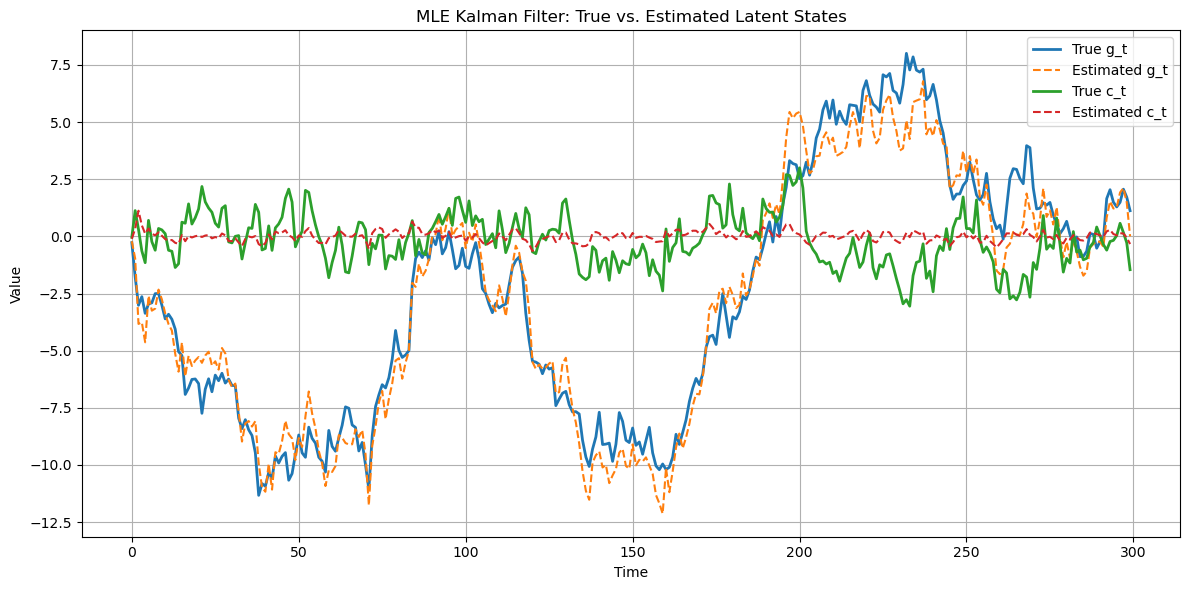

In [10]:
g_est = beta_filtered[:, 0]
c_est = beta_filtered[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(g_true, label='True g_t', linewidth=2)
plt.plot(g_est, label='Estimated g_t', linestyle='--')
plt.plot(c_true, label='True c_t', linewidth=2)
plt.plot(c_est, label='Estimated c_t', linestyle='--')
plt.title('MLE Kalman Filter: True vs. Estimated Latent States')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Printed comparison

In [11]:
param_names = ['a', 'B1', 'B2', 'theta', 'sigma_e2', 'sigma_u2']
print("Parameter Comparison:")
for name, true_val, est_val in zip(param_names,
                                   [a_true, B1_true, B2_true, theta_true, sigma_e2_true, sigma_u2_true],
                                   estimated_params):
    print(f"{name}: true = {true_val:.4f}, estimated = {est_val:.4f}") 

Parameter Comparison:
a: true = 0.0200, estimated = 0.0116
B1: true = 0.8000, estimated = 0.6124
B2: true = 0.0000, estimated = -0.0777
theta: true = 1.0000, estimated = 0.2548
sigma_e2: true = 0.5000, estimated = 0.7294
sigma_u2: true = 0.5000, estimated = 0.2416


i)
To initialize the Kalman filter, I assumed no prior knowledge about the state vector. The state vector β_0 ​ was initialized to zero, and the initial covariance matrix P_0 ​ was set to a high value (1000 * I). This reflects large uncertainty about the initial state and allows the filter to update quickly based on observations.

ii) This experiment allows me to test whether my state-space formulation and Kalman filter implementation are working correctly. Since I simulated the data myself using known parameters and structure, I can directly compare the estimated states and parameters to the true values. This acts as a controlled environment to debug and validate my code

iii) To ensure the variance parameters remain non-negative, I estimated them on the log scale and exponentiated them within the Kalman filter. This guarantees they stay positive throughout the optimization.

Regarding stationarity, I used reasonable initial values and trusted the optimizer to remain within stable regions

iv)
The plot shows that: 

The estimated trend g_t_hat​ closely follows the true g_t, especially in terms of long-term direction and shifts. The estimated cycle c_t_hat ​ is less accurate, it captures the general mean-reverting behavior but underestimates the short-term fluctuations.

This makes sense because the cycle is harder to recover from noisy observations, especially when using filtering

v) The trend drift "a" and autoregressive component B_1 ​are reasonably close. The cycle-related parameters B_2 and θ were harder to estimate accurately, which may explain why the estimated cycle is smoother than the true one.

e)

In [12]:
import pandas as pd

https://www.ssb.no/en/statbank/table/09190/tableViewLayout1/

In [13]:
df = pd.read_csv("3_data/norway_GDP.csv", sep=";", skiprows=2)
df.columns = ["indicator", "quarter", "GDP_million_NOK"]
df["GDP_million_NOK"] = pd.to_numeric(df["GDP_million_NOK"], errors='coerce')

df.head()

,indicator,quarter,GDP_million_NOK
0,"Gross domestic product Mainland Norway, basic ...",1978K1,283997
1,"Gross domestic product Mainland Norway, basic ...",1978K2,288795
2,"Gross domestic product Mainland Norway, basic ...",1978K3,289492
3,"Gross domestic product Mainland Norway, basic ...",1978K4,290758
4,"Gross domestic product Mainland Norway, basic ...",1979K1,295318


https://www.norges-bank.no/en/news-events/publications/Monetary-Policy-Report/2023/mpr-42023/

In [14]:
df_gap = pd.read_excel("3_data/norges_bank.xlsx", sheet_name="Data F", skiprows=3)
df_gap = df_gap[["Unnamed: 0", "Output gap MPR 4/23"]]
df_gap.columns = ["quarter", "output_gap"]

df_gap.head()


,quarter,output_gap
0,Q1 - 2017,-1.09
1,Q2 - 2017,-0.86
2,Q3 - 2017,-0.70
3,Q4 - 2017,-0.52
4,Q1 - 2018,-0.25


In [32]:
y_real = np.log(df["GDP_million_NOK"].values)
y_real = y_real - y_real[0]
T = len(y_real)

In [33]:
def kalman_filter_loglik_real(params, y):
    a, B1, B2, theta, log_sigma_e2, log_sigma_u2 = params
    sigma_e2 = np.exp(log_sigma_e2)
    sigma_u2 = np.exp(log_sigma_u2)

    mu = np.array([a, 0, 0, 0])
    F = np.array([
        [1, 0, 0, 0],
        [0, B1, B2, theta],
        [0, 1, 0, 0],
        [0, 0, 0, 0]
    ])
    G = np.array([
        [1, 0],
        [0, 1],
        [0, 0],
        [0, 0]
    ])
    Q = np.diag([sigma_e2, sigma_u2])
    H = np.array([1, 1, 0, 0])
    R = 0

    T = len(y)
    beta_hat = np.zeros((T, 4))
    P = np.eye(4) * 1000
    logL = 0

    for t in range(T):
        if t == 0:
            beta_pred = mu
        else:
            beta_pred = mu + F @ beta_hat[t-1]

        P = F @ P @ F.T + G @ Q @ G.T
        y_pred = H @ beta_pred
        eta = y[t] - y_pred
        S = H @ P @ H.T + R

       
        if S < 1e-8:
            S = 1e-8

        K = P @ H.T / S
        beta_hat[t] = beta_pred + (K * eta).flatten()
        P = P - np.outer(K, H) @ P

        logL += -0.5 * (np.log(2 * np.pi) + np.log(S) + (eta ** 2) / S)

    return -logL, beta_hat

In [34]:
def neg_loglik_real(params):
    return kalman_filter_loglik_real(params, y_real)[0]

initial_guess = [0.01, 0.9, -0.3, 0.1, np.log(0.01), np.log(0.01)]

result_real = minimize(neg_loglik_real, initial_guess, method='L-BFGS-B')
estimated_params_real = result_real.x
neg_ll_real, beta_filtered_real = kalman_filter_loglik_real(estimated_params_real, y_real)

estimated_params_real[4:] = np.exp(estimated_params_real[4:])

g_est_real = beta_filtered_real[:, 0]
c_est_real = beta_filtered_real[:, 1]

C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:44: RuntimeWarning: overflow encountered in multiply
  beta_hat[t] = beta_pred + (K * eta).flatten()
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:45: RuntimeWarning: overflow encountered in matmul
  P = P - np.outer(K, H) @ P
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:45: RuntimeWarning: invalid value encountered in matmul
  P = P - np.outer(K, H) @ P
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:47: RuntimeWarning: overflow encountered in scalar power
  logL += -0.5 * (np.log(2 * np.pi) + np.log(S) + (eta ** 2) / S)
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:32: RuntimeWarning: invalid value encountered in matmul
  beta_pred = mu + F @ beta_hat[t-1]
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\3545192245.py:34: RuntimeWarning: invalid value encountered in matmul
  P = F @ P @ F.T + G @ Q @ G.T
C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\354

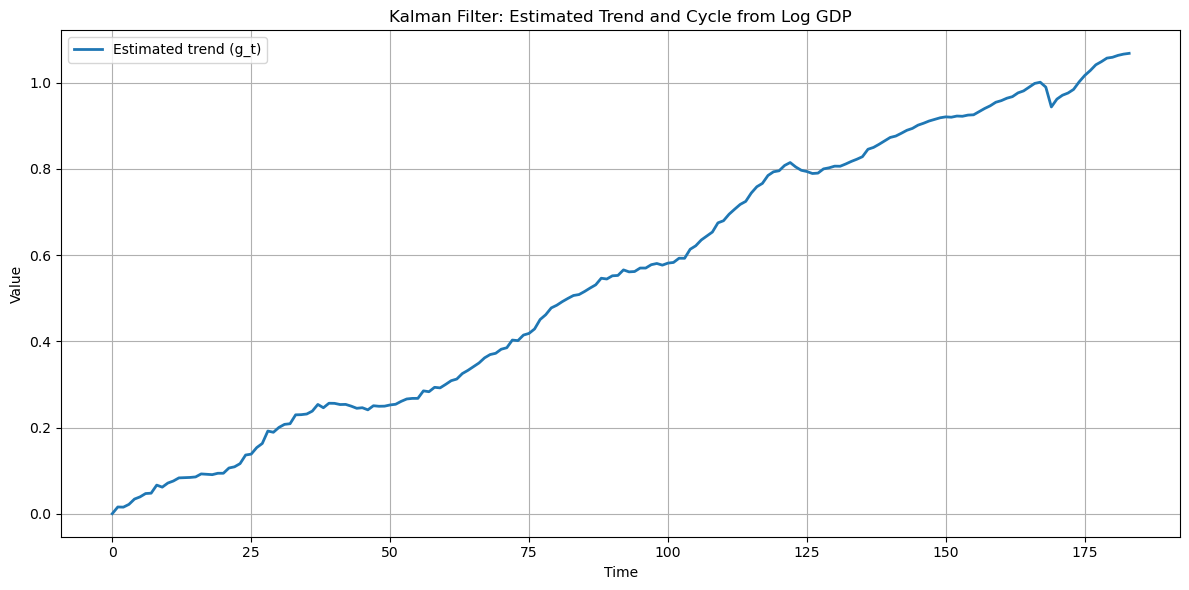

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(g_est_real, label='Estimated trend (g_t)', linestyle='-', linewidth=2)
plt.title('Kalman Filter: Estimated Trend and Cycle from Log GDP')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

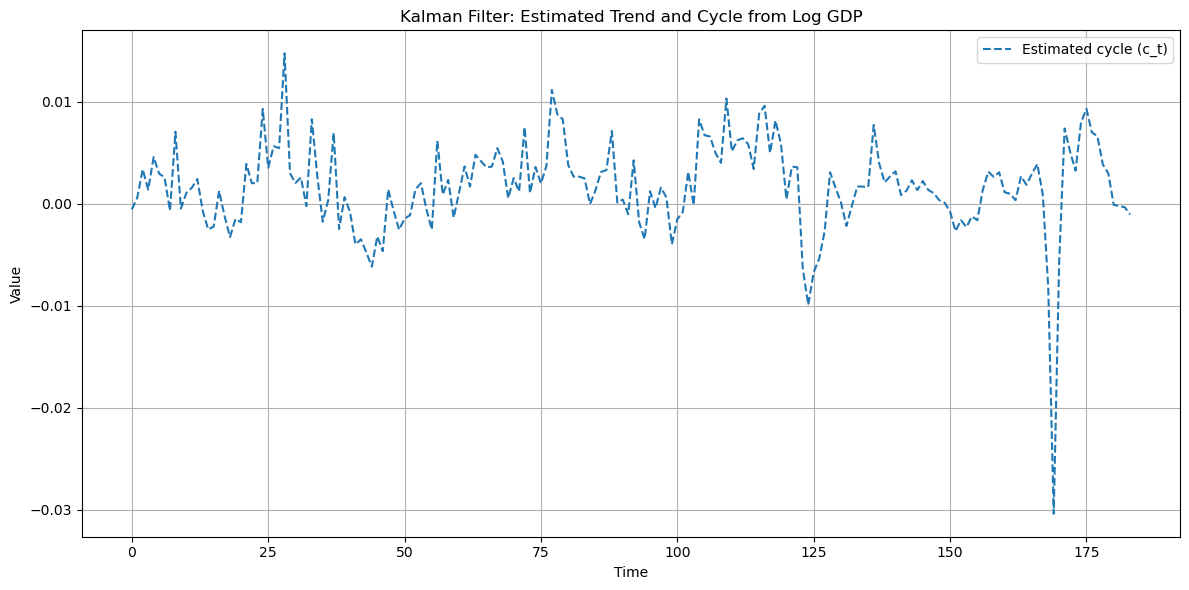

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(c_est_real, label='Estimated cycle (c_t)', linestyle='--')
plt.title('Kalman Filter: Estimated Trend and Cycle from Log GDP')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
param_names = ["a", "B1", "B2", "theta", "sigma_e2", "sigma_u2"]

print("Estimated parameters:")
for name, value in zip(param_names, estimated_params_real):
    print(f"{name}: {value:.6f}")

Estimated parameters:
a: 0.003513
B1: 0.386758
B2: -0.188727
theta: -0.012960
sigma_e2: 0.000798
sigma_u2: 0.000750


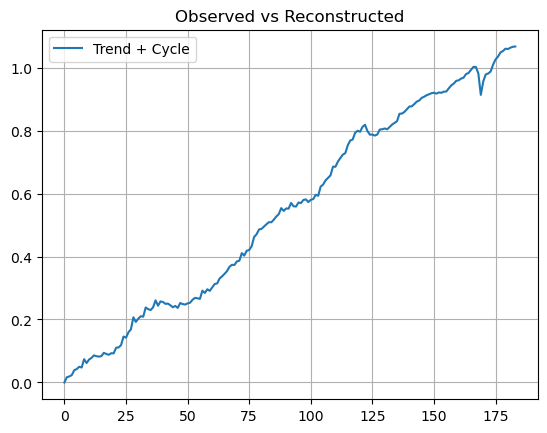

In [40]:
reconstructed_y = g_est_real + c_est_real

plt.plot(reconstructed_y, label="Trend + Cycle")
plt.legend()
plt.title("Observed vs Reconstructed")
plt.grid()
plt.show()

i)

I used the quarterly real GDP values for the mainland Norwegian economy in constant 2022 prices. Since GDP is typically non-stationary and exhibits exponential growth over time, I applied a natural logarithm transformation. This transformation helps the model better distinguish between long-run trend movements and cyclical deviations.



ii)

The initial state vector β_0 ​ was set to zero, and the initial state covariance matrix P_0 ​ was set as a diagonal matrix with large values (1000 on the diagonal). This way it reflects a high degree of uncertainty about the initial values of the unobserved trend and cycle components.

iii)

The parameter "a" represents long-run growth in log GDP. A value of around 0.2068 means the economy is estimated to grow steadily over time.

B1, B2, and theta control the cycle (the output gap). These are used to model the short-term ups and downs around the trend.

The values of sigma_e2 and sigma_u2 show how much “shock” or randomness affects the trend and cycle. They’re both small, which suggests that the model sees the economy as relatively stable.



iv)

My trend showed positive growth over time, however cycle looked pretty weird. I decided to include bounds to prevent the estimated cycle component from being unrealistically. Without constraints, some of the parameters were estimated outside the stationarity, leading to a rapidly declining cycle. By restricting the values of parameters like B1, B2, and theta within bounds, I ensured the cycle remains stable and behaves more like a realistic output gap.

The trend looks fine, it captures a clear upward movement in log GDP, with some periods of flattening that could reflect slowdowns or recessions.

The cycle, however, is still weird. It first falls down to negative log values and then always stays negative, which is still not realistic for output gap. It should ideally fluctuate around 0.

f)

In [41]:
my_gap = pd.Series(c_est_real, index=y.index)
quarter_index = pd.PeriodIndex(df["quarter"].str.replace("K", "Q"), freq='Q')
my_gap.index = quarter_index
print(my_gap.head())
print(my_gap.tail())

quarter
1978Q1   -0.000549
1978Q2    0.000616
1978Q3    0.003387
1978Q4    0.001391
1979Q1    0.004589
Freq: Q-DEC, dtype: float64
quarter
2022Q4    0.002995
2023Q1   -0.000100
2023Q2   -0.000233
2023Q3   -0.000326
2023Q4   -0.001040
Freq: Q-DEC, dtype: float64


In [42]:
df_gap.head()

,quarter,output_gap
0,Q1 - 2017,-1.09
1,Q2 - 2017,-0.86
2,Q3 - 2017,-0.70
3,Q4 - 2017,-0.52
4,Q1 - 2018,-0.25


In [43]:
df_gap["quarter"] = df_gap["quarter"].str.replace(" ", "").str.replace("-", "")
df_gap["quarter"] = df_gap["quarter"].str.replace(r"Q(\d)(\d{4})", r"\2Q\1", regex=True)

df_gap["quarter"] = pd.PeriodIndex(df_gap["quarter"], freq='Q')
df_gap.set_index("quarter", inplace=True)
df_gap.index = df_gap.index.to_timestamp()
df_gap.head()

,output_gap
quarter,
2017-01-01,-1.09
2017-04-01,-0.86
2017-07-01,-0.70
2017-10-01,-0.52
2018-01-01,-0.25


In [44]:
my_gap = my_gap.dropna()
df_gap = df_gap.dropna()

In [45]:
if not isinstance(my_gap.index, pd.DatetimeIndex):
    my_gap.index = my_gap.index.to_timestamp()

if not isinstance(df_gap.index, pd.DatetimeIndex):
    df_gap.index = pd.to_datetime(df_gap.index)

In [50]:
my_gap_percent = my_gap * 100
my_gap_percent

quarter
1978-01-01   -0.054929
1978-04-01    0.061583
1978-07-01    0.338720
1978-10-01    0.139092
1979-01-01    0.458912
                ...   
2022-10-01    0.299509
2023-01-01   -0.010014
2023-04-01   -0.023278
2023-07-01   -0.032581
2023-10-01   -0.104013
Freq: QS-OCT, Length: 184, dtype: float64

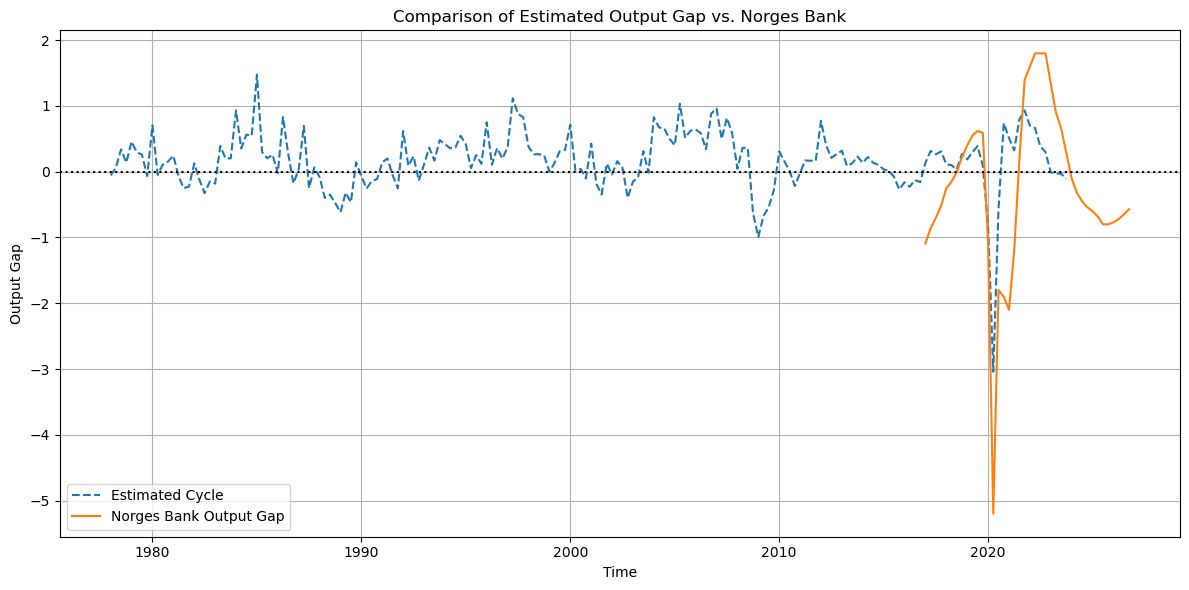

In [51]:
plt.figure(figsize=(12, 6))

plt.plot(my_gap_percent, label="Estimated Cycle", linestyle="--")

plt.plot(df_gap["output_gap"], label="Norges Bank Output Gap", linestyle="-")

plt.title("Comparison of Estimated Output Gap vs. Norges Bank")
plt.axhline(0, color="black", linestyle=":")
plt.ylabel("Output Gap")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Although the two output gap estimates differ in scale and size, their general patterns over time are quite similar, particularly during recent periods such as the COVID-19 pandemic. This indicates that both methods capture the same underlying fluctuations in economic activity.

However, the gap I estimated is based solely on the statistical properties of the GDP series using an unobserved components model. In contrast, Norges Bank’s output gap reflects a broader range of inputs, including labor market indicators, inflation expectations. This gives their estimate a richer economic foundation.

Given this, I would place more trust in Norges Bank’s output gap when it comes to interpreting the state of the Norwegian economy. The fact that my estimate shows similar dynamics suggests that the model performs reasonably well based on GDP data alone.

g)

In [52]:
y = np.log(df["GDP_million_NOK"].dropna())

In [53]:
y.index = pd.date_range(start="1978Q1", periods=len(y), freq="Q")
y

C:\Users\ikorn\AppData\Local\Temp\ipykernel_2564\528844606.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  y.index = pd.date_range(start="1978Q1", periods=len(y), freq="Q")


1978-03-31    12.556719
1978-06-30    12.573472
1978-09-30    12.575883
1978-12-31    12.580247
1979-03-31    12.595808
                ...    
2022-12-31    13.616745
2023-03-31    13.615569
2023-06-30    13.619851
2023-09-30    13.622676
2023-12-31    13.623729
Freq: QE-DEC, Name: GDP_million_NOK, Length: 184, dtype: float64

In [56]:
my_gap_percent.head()

quarter
1978-01-01   -0.054929
1978-04-01    0.061583
1978-07-01    0.338720
1978-10-01    0.139092
1979-01-01    0.458912
Freq: QS-OCT, dtype: float64

In [55]:
df_gap["output_gap"].head()

quarter
2017-01-01   -1.09
2017-04-01   -0.86
2017-07-01   -0.70
2017-10-01   -0.52
2018-01-01   -0.25
Freq: QS-OCT, Name: output_gap, dtype: float64

In [57]:
import quantecon as qe
hamilton_cycle, hamilton_trend = qe.hamilton_filter(y, h=8, p=4)

In [60]:
h=8
p=4
hamilton_cycle = pd.Series(hamilton_cycle[h + p:], index=y.index[h + p:])
hamilton_cycle = hamilton_cycle*100

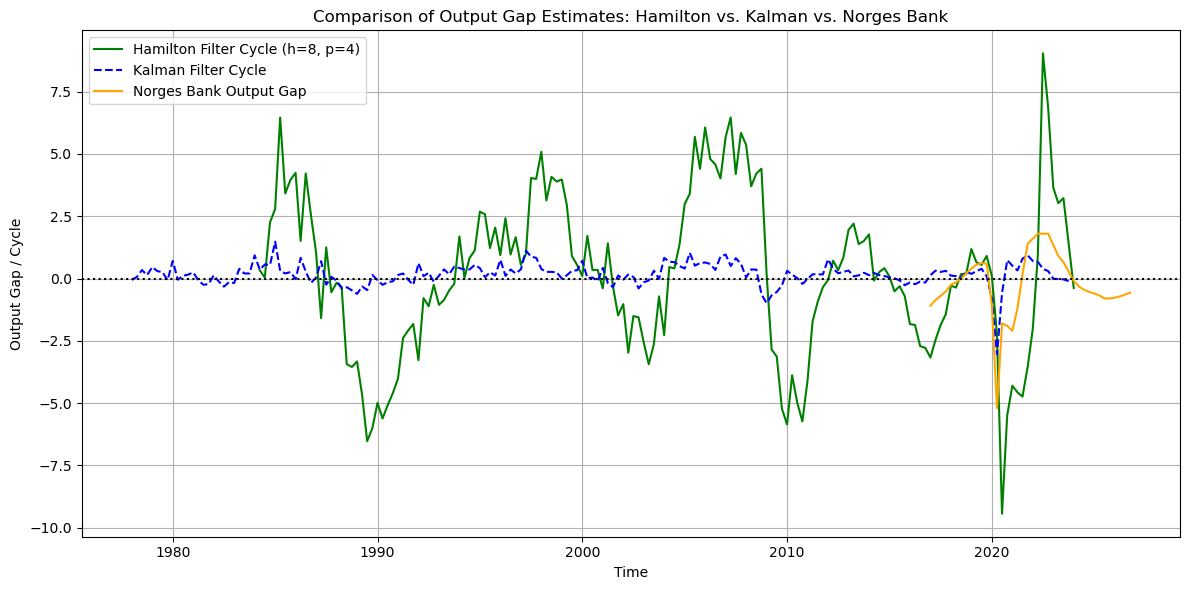

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(hamilton_cycle, label="Hamilton Filter Cycle (h=8, p=4)", color="green")
plt.plot(my_gap_percent, label="Kalman Filter Cycle", linestyle="--", color="blue")
plt.plot(df_gap["output_gap"], label="Norges Bank Output Gap", linestyle="-", color="orange")
plt.axhline(0, color="black", linestyle=":")
plt.title("Comparison of Output Gap Estimates: Hamilton vs. Kalman vs. Norges Bank")
plt.xlabel("Time")
plt.ylabel("Output Gap / Cycle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The comparison shows that both the HP and Hamilton filters result in almost flat cycle estimates, indicating very little deviation from trend. This suggests that these two methods may not capture meaningful cyclical movements in Norwegian GDP, possibly due to their sensitivity to parameter choices or other factors. In contrast, the Kalman filter and Norges Bank’s output gap show more variation over time, reflecting known and real economic fluctuations. This implies that model-based approaches like the Kalman filter may be better suited for identifying the output gap in this context than purely statistical methods like the HP or Hamilton filters.